In [ ]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/My Drive/cityscapes_data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')


In [ ]:
train_fnames = os.listdir(train_dir)
val_fnames = os.listdir( validation_dir )

print(train_fnames[:10])
print(val_fnames[:10])

['2870.jpg', '419.jpg', '42.jpg', '320.jpg', '400.jpg', '2883.jpg', '276.jpg', '2573.jpg', '2578.jpg', '2954.jpg']
['486.jpg', '235.jpg', '301.jpg', '20.jpg', '429.jpg', '170.jpg', '77.jpg', '255.jpg', '113.jpg', '107.jpg']


In [ ]:
print('total training images :', len(os.listdir(train_dir ) ))
print('total validation images :', len(os.listdir( validation_dir ) ))

total training images : 2975
total validation images : 500


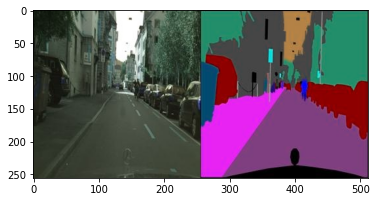

(256, 512, 3)


In [ ]:
fname=train_fnames[0]
flist = os.path.join(train_dir, fname)
img0 = cv2.imread(flist)
plt.imshow(img0)
plt.show()
print(np.shape(img0))

In [ ]:
#reading the actual images and forming them into the training dataset
szy,szx,_ = np.shape(img0)
print(szy,szx,_)
N_ex = 1800
N_bias = 0
x_train = np.zeros((N_ex,szy,int(szx/2),3))
y_train = np.zeros((N_ex,szy,int(szx/2),3))


256 512 3


In [ ]:
print(len(train_fnames[N_bias:N_bias+N_ex]))

1800


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


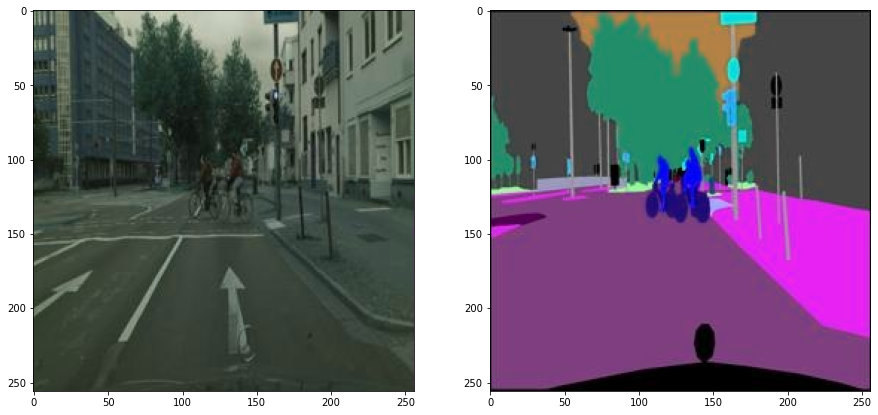

In [ ]:
k=0
for f in train_fnames[N_bias:N_bias+N_ex]:
    fname=f
    flist = os.path.join(train_dir, fname)
    
    if k%100 == 0:
      print(k)
    x_train[k] = cv2.imread(flist)[:,:256]/256
    y_train[k] = cv2.imread(flist)[:,256:]/256
    k = k+1
    
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(x_train[1])
plt.subplot(1,2,2)
plt.imshow(y_train[1])

In [ ]:
# same for validation data set
fname=val_fnames[0]
flist = os.path.join(validation_dir, fname)
img0 = cv2.imread(flist)
N_val = 100

szy,szx,_ = np.shape(img0)
x_val = np.zeros((N_val,szy,int(szx/2),3))
y_val = np.zeros((N_val,szy,int(szx/2),3))
k = 0;

for f in val_fnames[0:N_val]:
    fname=val_fnames[k]
    flist = os.path.join(validation_dir, fname)
    if k%50 == 0:
      print(k)
    x_val[k] = cv2.imread(flist)[:,:256]/256
    y_val[k] = cv2.imread(flist)[:,256:]/256
    k = k+1

0
50


In [ ]:
#u-net architecture
import tensorflow as tf
import keras

from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.layers.convolutional import Conv2D
from keras.models import Sequential, Model, model_from_json, load_model
from keras.regularizers import l2

In [ ]:
# define conv_factory: batch normalization + ReLU + Conv2D + Dropout (optional)
def conv_factory(x, concat_axis, nb_filter,
                 dropout_rate=None, weight_decay=1E-4):
    x = BatchNormalization(axis=concat_axis,
                           gamma_regularizer=l2(weight_decay),
                           beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter, (5, 5), dilation_rate=(2, 2),
               kernel_initializer="he_uniform",
               padding="same",
               kernel_regularizer=l2(weight_decay))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
  
    return x

In [ ]:
# define dense block: a nb_layers stack of conv_factory layers merged together
def denseblock(x, concat_axis, nb_layers, growth_rate, dropout_rate=None, weight_decay=1E-4):
    list_feat = [x]
    for i in range(nb_layers):
        x = conv_factory(x, concat_axis, growth_rate,dropout_rate, weight_decay)
        list_feat.append(x)
    x = Concatenate(axis=concat_axis)(list_feat)

    return x

In [ ]:
#the same model, but without the skip connections
def u_net_wihtout_skips():
    dr = 0.5
    nr = 2
    mod_inputs = Input((256,256,3))
    print("inputs shape:", mod_inputs.shape)

    conv1 = Conv2D(64/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mod_inputs)
    print("conv1 shape:", conv1.shape)
    db1 = denseblock(x=conv1, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db1 shape:", db1.shape)
    pool1 = MaxPooling2D(pool_size=(2, 2))(db1)
    print("pool1 shape:", pool1.shape)

    conv2 = Conv2D(128/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    print("conv2 shape:", conv2.shape)
    db2 = denseblock(x=conv2, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db2 shape:", db2.shape)
    pool2 = MaxPooling2D(pool_size=(2, 2))(db2)
    print("pool2 shape:", pool2.shape)

    conv3 = Conv2D(256/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    print("conv3 shape:", conv3.shape)
    db3 = denseblock(x=conv3, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db3 shape:", db3.shape)
    pool3 = MaxPooling2D(pool_size=(2, 2))(db3)
    print("pool3 shape:", pool3.shape)

    conv4 = Conv2D(512/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    print("conv4 shape:", conv4.shape)
    db4 = denseblock(x=conv4, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db4 shape:", db4.shape)
    pool4 = MaxPooling2D(pool_size=(2, 2))(db4)
    print("pool4 shape:", pool4.shape)
###############################################################################################################
    conv5 = Conv2D(1024/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    print("conv5 shape:", conv5.shape)
    db5 = denseblock(x=conv5, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=dr)
    print("db5 shape:", db5.shape)
    up5 = Conv2D(512/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(db5))
    print("up5 shape:", up5.shape)
    #merge5 = Concatenate(axis=3)([ BatchNormalization()(db4), BatchNormalization()( up5)])
    #print("merge5 shape:", merge5.shape)

    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up5) #was merge5
    print("conv6 shape:", conv6.shape)
    db6 = denseblock(x=conv6, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=dr)
    print("db5 shape:", db6.shape)
    up6 = Conv2D(256/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(db6))
    print("up6 shape:", up6.shape)
    #merge6 = Concatenate(axis=3)([BatchNormalization()(db3), BatchNormalization()(up6)])
    #print("merge6 shape:", merge6.shape)

    conv7 = Conv2D(256/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up6)#was merge6
    print("conv7 shape:", conv7.shape)
    db7 = denseblock(x=conv7, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db7 shape:", db7.shape)
    up7 = Conv2D(128/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db7))
    print("up7 shape:", up7.shape)
    #merge7 = Concatenate(axis=3)([BatchNormalization()(db2), BatchNormalization()(up7)])
    #print("merge7 shape:", merge7.shape)

    conv8 = Conv2D(128/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up7) #was merge7
    print("conv8 shape:", conv8.shape)
    db8 = denseblock(x=conv8, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db8 shape:", db8.shape)
    up8 = Conv2D(64/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db8))
    print("up8 shape:", up8.shape)
    #merge8 = Concatenate(axis=3)([BatchNormalization()(db1), BatchNormalization()(up8)])
    #print("merge8 shape:", merge8.shape)

    conv9 = Conv2D(64/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up8)#was merge8
    print("conv9 shape:", conv9.shape)
    db9 = denseblock(x=conv9, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db9 shape:", db9.shape)
    conv10 = Conv2D(32/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(db9)
    print("conv10 shape:", conv10.shape)
    conv11 = Conv2D(3, 1, activation='sigmoid')(conv10)
    print("conv11 shape:", conv11.shape)

    model = Model(inputs=mod_inputs, outputs=conv11)
    model.compile(optimizer='adam', loss = 'MSE')
    
    return model

In [ ]:
model_nc=u_net_wihtout_skips()

inputs shape: (None, 256, 256, 3)
conv1 shape: (None, 256, 256, 32)
db1 shape: (None, 256, 256, 96)
pool1 shape: (None, 128, 128, 96)
conv2 shape: (None, 128, 128, 64)
db2 shape: (None, 128, 128, 128)
pool2 shape: (None, 64, 64, 128)
conv3 shape: (None, 64, 64, 128)
db3 shape: (None, 64, 64, 192)
pool3 shape: (None, 32, 32, 192)
conv4 shape: (None, 32, 32, 256)
db4 shape: (None, 32, 32, 320)
pool4 shape: (None, 16, 16, 320)
conv5 shape: (None, 16, 16, 512)
db5 shape: (None, 16, 16, 560)
up5 shape: (None, 32, 32, 256)
conv6 shape: (None, 32, 32, 512)
db5 shape: (None, 32, 32, 560)
up6 shape: (None, 64, 64, 128)
conv7 shape: (None, 64, 64, 128)
db7 shape: (None, 64, 64, 160)
up7 shape: (None, 128, 128, 64)
conv8 shape: (None, 128, 128, 64)
db8 shape: (None, 128, 128, 96)
up8 shape: (None, 256, 256, 32)
conv9 shape: (None, 256, 256, 32)
db9 shape: (None, 256, 256, 64)
conv10 shape: (None, 256, 256, 16)
conv11 shape: (None, 256, 256, 3)


In [ ]:
model_nc.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
his_nc = model_nc.fit(x_train, y_train, epochs=5, shuffle = True, batch_size= 10, validation_data=(x_val, y_val))

Epoch 1/5
180/180 [==============================] - 90s 503ms/step - loss: 0.2775 - val_loss: 0.2076
Epoch 2/5
180/180 [==============================] - 93s 516ms/step - loss: 0.1566 - val_loss: 0.1338
Epoch 3/5
180/180 [==============================] - 93s 515ms/step - loss: 0.1062 - val_loss: 0.0916
Epoch 4/5
180/180 [==============================] - 93s 515ms/step - loss: 0.0728 - val_loss: 0.0627
Epoch 5/5
180/180 [==============================] - 93s 517ms/step - loss: 0.0511 - val_loss: 0.0474


In [ ]:
model_nc.save('cityscapemodel4.h5')

In [ ]:
 pp_nc = model_nc.predict(x_val[0:20,:,:,:])

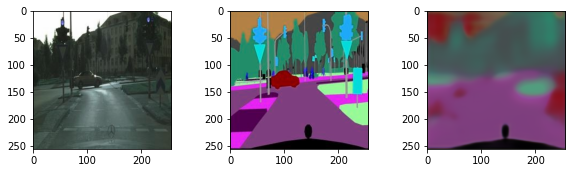

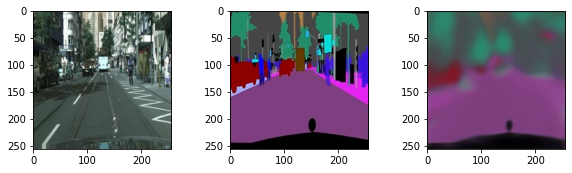

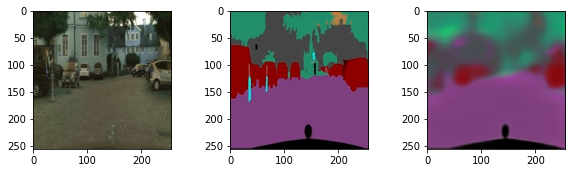

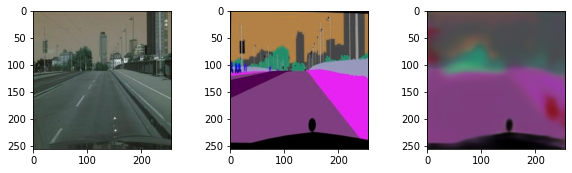

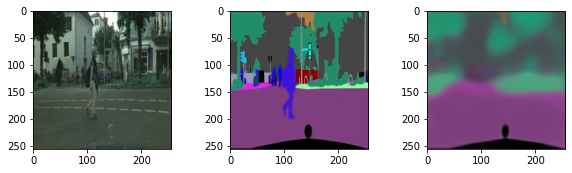

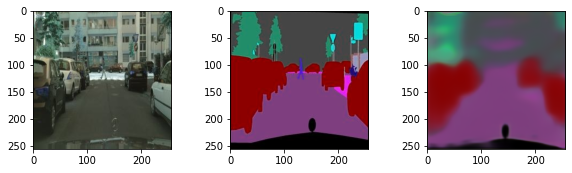

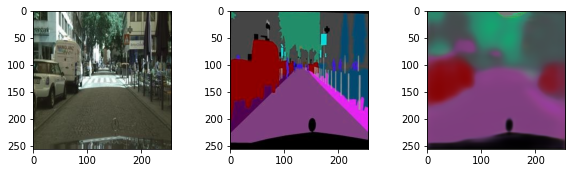

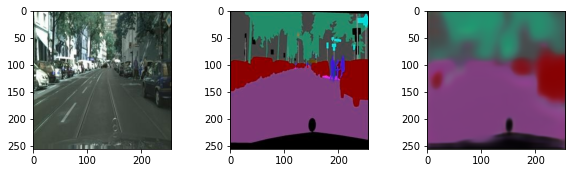

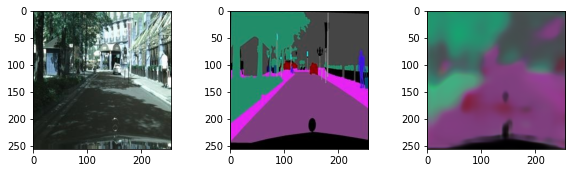

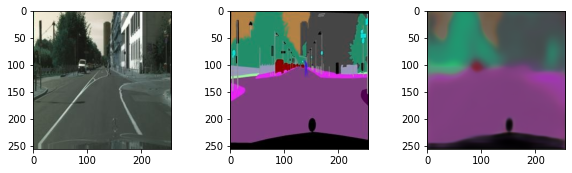

In [ ]:
#show the result
ni = 10
for k in range(ni):

    plt.figure(figsize=(10,30))
    plt.subplot(ni,3,1+k*3)
    plt.imshow(x_val[k])
    plt.subplot(ni,3,2+k*3)
    plt.imshow(y_val[k])
    plt.subplot(ni,3,3+k*3)
    plt.imshow(pp_nc[k])

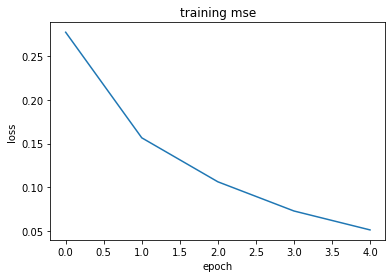

In [ ]:
#training mse
plt.title('training mse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(his_nc.history['loss'])

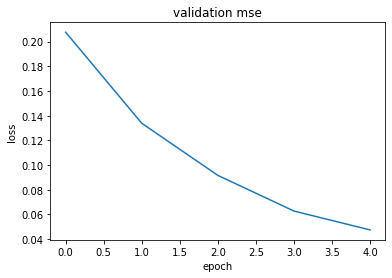

In [ ]:
#validation mse
plt.title('validation mse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(his_nc.history['val_loss'])